ФИО: Якимов Борис Павлович

In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
from torchvision.models import vgg16, alexnet
import torchvision.transforms as transforms
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 Задание: выкинуть последний слой из vgg / alexnet и обучить линейную регрессиию на выходах полученных сетей.
Например, для mnist.

In [2]:
alex = alexnet(pretrained=True)

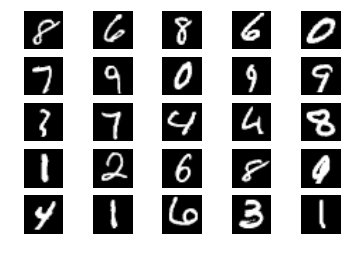

In [3]:
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images = np.stack((images,images,images),axis=2).reshape(70000,3,28,28)

images_train, images_test, labels_train, labels_test = train_test_split(images, labels)

for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')

In [4]:
from skimage import transform

In [5]:
def rotate_images(batch):
    angle = np.random.randint(-20,20,size=batch.shape[0])
    new_batch = np.zeros(shape=batch.shape)
    
    for i,image in enumerate(batch):
        image = np.swapaxes(image,axis1=0,axis2=2)
        image = transform.rotate(image,angle[i])
        image =  np.swapaxes(image,axis1=0,axis2=2)
        new_batch[i] = image
        
    return new_batch

In [17]:
class ConvNet_2(torch.nn.Module):
    def __init__(self):
        super(ConvNet_2, self).__init__()
        
        self.convert = torch.nn.UpsamplingNearest2d(size=(224,224))
        self.feature_extractor = alex.features
        for layer in self.feature_extractor:
            for par in layer.parameters():
                par.requires_grad = False
                
        self.linear_layers = torch.nn.Sequential(torch.nn.Linear(256*6*6, 10), torch.nn.LogSoftmax())
    
    def forward(self, x):
        x = self.convert(x)
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
    def predict_proba(self,x):
        return torch.exp(self.forward(x))
    
    def predict(self,x):
        return self.predict_proba(x).data.numpy().argmax(axis=1)

In [18]:
network = ConvNet_2()
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(network.linear_layers.parameters(),lr=1e-3,weight_decay=1e-4)

In [19]:
import tqdm

In [20]:
batch_size = 4
n_epochs = 10
loss_epochs = []
for j in tqdm.tqdm(xrange(n_epochs)):
    losses = []
    for i in xrange(0,50000,batch_size):
        batch = images_train[i:i+batch_size]
        #new_batch = rotate_images(batch)
        x = Variable(torch.from_numpy(batch),requires_grad=False).type(torch.FloatTensor)
        y = Variable(torch.from_numpy(labels_train[i:i+batch_size]),requires_grad=False).type(torch.LongTensor)

        a = network(x)
        loss = loss_fn(a,y)
        losses.append(loss.data[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_epochs.append(np.mean(losses,axis=0))
    print "loss epoch", loss_epochs[-1]

 10%|█         | 1/10 [31:03<4:39:35, 1863.91s/it]

loss epoch 230.8751157


 20%|██        | 2/10 [1:01:18<4:06:32, 1849.04s/it]

loss epoch 107.490611401


 30%|███       | 3/10 [1:31:28<3:34:21, 1837.32s/it]

loss epoch 79.2737577107


 40%|████      | 4/10 [2:01:39<3:02:56, 1829.42s/it]

loss epoch 64.5185350505


 50%|█████     | 5/10 [2:31:49<2:31:58, 1823.60s/it]

loss epoch 53.5027801043


 60%|██████    | 6/10 [3:01:59<2:01:18, 1819.56s/it]

loss epoch 41.8813255831


 70%|███████   | 7/10 [3:32:02<1:30:44, 1814.75s/it]

loss epoch 34.8405580738


 80%|████████  | 8/10 [4:02:08<1:00:23, 1811.87s/it]

loss epoch 33.1814034749


 90%|█████████ | 9/10 [4:32:24<30:13, 1813.24s/it]  

loss epoch 28.7811210284


100%|██████████| 10/10 [5:02:34<00:00, 1812.37s/it]

loss epoch 24.5528143963


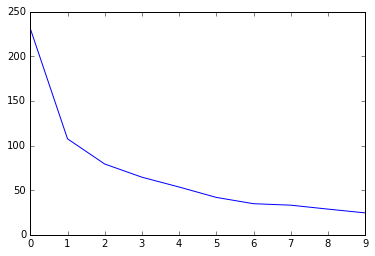

In [21]:
plt.plot(loss_epochs)

In [22]:
def make_predictions(network,images_test):
    predictions = []
    for i in tqdm.tqdm(xrange(0,images_test.shape[0],2)):
        x_test = Variable(torch.from_numpy(images_test[i:i+2])).type(torch.FloatTensor)
        y_pred = network.predict(x_test)
        predictions.extend(y_pred)
    return np.array(predictions)

In [23]:
predictions = make_predictions(network,images_test)

100%|██████████| 8750/8750 [13:04<00:00, 11.16it/s]


In [13]:
from sklearn.metrics import accuracy_score

In [24]:
accuracy_score(labels_test,predictions)

0.97205714285714284